In [ ]:
# Setting up the analysis. Don't touch unless necessary
# https://www.cms.gov/medicare/payment/prospective-payment-systems/acute-inpatient-pps/ms-drg-classifications-and-software

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mticker

# local file from hospital, unfortunately I cannot provide this externally
AAA = pd.read_excel('AAA_wEverything_2023_12_08.xlsx')
AAA.set_index('EPIC',verify_integrity=True, inplace=True)

# create these columns here rather than in csv or excel
AAA['TOTAL_COSTS'] = AAA['PRO_COSTS'] + AAA['HOS_COSTS']
AAA['TOTAL_PAYMENTS'] = AAA['PRO_PAYMENT'] + AAA['HOS_PAYMENTS']
AAA['NET_INCOME'] = AAA['TOTAL_PAYMENTS'] - AAA['TOTAL_COSTS']

# Bill paid? yay or nay?
AAA_Outst = AAA[AAA['ANY_OUTSTANDING']==1]
AAA_NoOut = AAA[AAA['ANY_OUTSTANDING']==0]

# Analysis focuses on Medicare with no outstanding balances
Med_Only = AAA_NoOut[AAA_NoOut['PAYOR']=='MED']

#splitting by rupture status
rupture = Med_Only[Med_Only['Rupture_Flag']==1]
no_rupt = Med_Only[Med_Only['Rupture_Flag']==0]

In [ ]:
def proc_numbers(df=AAA):
# Assign a unique number to each distinct procedure
    df['Procedure_Number'], uniques = pd.factorize(df['Surgery_Procedure'])
    procedure_counts = df['Surgery_Procedure'].value_counts().reset_index()
    procedure_counts.columns = ['Name', 'Count']
    procedure_counts['Procedure_Number'] = procedure_counts['Name'].map(uniques.get_loc)
    procedure_counts = procedure_counts[['Procedure_Number', 'Name', 'Count']]
    procedure_counts.set_index('Procedure_Number', inplace=True)
    print(procedure_counts)

# could combine cost_graph and payments_graph but this interface is easy to read
def costs_graph(df=AAA, total=True, hos=True, pro=False):
    # choose which of three (or all) cost graphs you want to show
    plt.figure(figsize=(14,8))
    if total:
        sns.histplot(df['TOTAL_COSTS'], color='red', kde=True, bins=100, label = 'Total Costs')
    if hos:
        sns.histplot(df['HOS_COSTS'], color='blue', kde=True, bins=100, label = 'Hospital Costs')
    if pro:
        sns.histplot(df['PRO_COSTS'], color='green', kde=True, bins=100, label = 'Professional Costs')
    plt.title('Distribution of Costs')
    plt.legend();

def payments_graph(df=AAA, total=True, hos=True, pro=False):
    # choose which of three (or all) payments graphs you want to show
    plt.figure(figsize=(14,8))
    if total:
        sns.histplot(df['TOTAL_PAYMENTS'], color='red', kde=True, bins=100, label = 'Total Costs')
    if hos:
        sns.histplot(df['HOS_PAYMENTS'], color='blue', kde=True, bins=100, label = 'Hospital Costs')
    if pro:
        sns.histplot(df['PRO_PAYMENT'], color='green', kde=True, bins=100, label = 'Professional Costs')
    plt.title('Distribution of Payments')
    plt.legend();

def NI_graph(df=AAA):
    # graphing profit and loss for each encounter. no hospital vs professional costs distinction here
    plt.figure(figsize=(14,8))
    sns.histplot(df['NET_INCOME'], color='red', kde=True, bins=100, label = 'Total Costs')
    plt.title('Distribution of Profit/(Loss) Per Encounter');

def paymentsandcosts_graph(datfra=AAA, ctotal=True, chos=True, cpro=False, ptotal=True, phos=True, ppro=False):
    # calls the three preceeding functions as one function call
    # ctotal = total costs, ptotal = total payments. other variables similarly defined
    costs_graph(df=datfra, total=ctotal, hos=chos, pro=cpro)
    payments_graph(df=datfra, total=ptotal, hos=phos,pro=ppro)
    NI_graph(df=datfra);

def paymentsandcosts_stats(df=AAA):
    print("Median of payments is : $", round(np.median(df['TOTAL_PAYMENTS']),1))
    print("Median of costs is : $", round(np.median(df['TOTAL_COSTS']),1))
    print("Median of net income is : $", round(np.median(df['NET_INCOME']),1))
    print("STD of payments is : $",round(np.std(df['TOTAL_PAYMENTS']),1))
    print("STD of costs is : $",round(np.std(df['TOTAL_COSTS']),1))
    print("STD of net income is : $", round(np.std(df['NET_INCOME']),1))

def graph_metrics(metric='median'):
    """generates a bar graph comparing the specified metric (median, mean, or standard deviation) of total payments,
       total costs, and net income across three different subsets of the data (AAA, AAA_Outst, AAA_NoOut)
    """
    # Set the positions and width for the bars
    positions = np.arange(3)  # Three positions for the three groups
    width = 0.2  # Width of each bar

    # Calculate means or medians for each dataframe
    if metric=='mean':
        values_func = np.mean
    elif metric=='std':
        values_func = np.std
    else:
        values_func = np.median

    values_AAA = [values_func(AAA['TOTAL_PAYMENTS']), values_func(AAA['TOTAL_COSTS']), values_func(AAA['NET_INCOME'])]
    values_AAA_Outst = [values_func(AAA_Outst['TOTAL_PAYMENTS']), values_func(AAA_Outst['TOTAL_COSTS']), values_func(AAA_Outst['NET_INCOME'])]
    values_AAA_NoOut = [values_func(AAA_NoOut['TOTAL_PAYMENTS']), values_func(AAA_NoOut['TOTAL_COSTS']), values_func(AAA_NoOut['NET_INCOME'])]

    # Plotting the bars
    fig, ax = plt.subplots(figsize=(11,3))

    # Create bars for each group
    ax.bar(positions - width, values_AAA, width, label='AAA')
    ax.bar(positions, values_AAA_Outst, width, label='Billed')
    ax.bar(positions + width, values_AAA_NoOut, width, label='Fin/Comp')

    # Adding labels to each bar
    for i in range(3):
        ax.text(i - width, values_AAA[i] + 1, round(values_AAA[i]/1000, 1), ha='center')
        ax.text(i, values_AAA_Outst[i] + 1, round(values_AAA_Outst[i]/1000, 1), ha='center')
        ax.text(i + width, values_AAA_NoOut[i] + 1, round(values_AAA_NoOut[i]/1000, 1), ha='center')

    ax.set_ylabel('Values')
    ax.set_title(f'Comparison of {metric} Values')
    ax.set_xticks(positions)
    ax.set_xticklabels(['TOTAL_PAYMENTS', 'TOTAL_COSTS', 'NET_INCOME'])
    ax.legend()

def plot_data_counts(size=(5,5),df1=AAA,df2=AAA_NoOut,df3=AAA_Outst):
    # count of individuals in each of three categories: Full, Finalized, or just Billed by default
    counts = [len(df1), len(df2), len(df3)]
    fig, ax = plt.subplots(figsize=size)
    ax.bar(['Full AAA', 'Final/Complete Only', 'Billed Only'], counts, color=['blue','green','black'])
    ax.set_title('Number of Patients')

def test_means(df1=AAA, df2=AAA_NoOut):
    # mean test, but assumes normalcy. test that first
    for col in ['TOTAL_PAYMENTS', 'TOTAL_COSTS', 'NET_INCOME']:
        t_stat, p_value = stats.ttest_ind(df1[col], df2[col])
        same = (p_value >= 0.05)
        print(col, "P-value:", np.round(p_value,3))
        print("Are they statistically the same?",same,"\n")

def skew_kurt_costs(df=AAA):
    """
    We do two normalcy tests for each of hospital, professional, and total costs.
    We also include kurtosis and skewness calculations.
    """
    print("K^2 D'Agostino Test for Normalcy:\n")
    stat, pval = stats.normaltest(df['HOS_COSTS'])
    print("P-value for Hospital Costs: ", pval)

    stat, pval = stats.normaltest(df['PRO_COSTS'])
    print("P-value for Professional Costs: ", pval)

    stat, pval = stats.normaltest(df['TOTAL_COSTS'])
    print("P-value for Total Costs: ", pval)

    print("\n\nKolmogorov-Smirnov Test for Normalcy:\n")
    scaler = StandardScaler()

    hos_scaled = scaler.fit_transform(df['HOS_COSTS'].values.reshape(-1,1)).flatten()
    pro_scaled = scaler.fit_transform(df['PRO_COSTS'].values.reshape(-1,1)).flatten()
    tot_scaled = scaler.fit_transform(df['TOTAL_COSTS'].values.reshape(-1,1)).flatten()

    stat, pval = stats.kstest(hos_scaled, 'norm')
    print("P-value for Hospital Costs: ", pval)

    stat, pval = stats.kstest(pro_scaled, 'norm')
    print("P-value for Professional Costs: ", pval)

    stat, pval = stats.kstest(tot_scaled, 'norm')
    print("P-value for Total Costs: ", pval)

    a = df['HOS_COSTS'].kurtosis()
    b = df['HOS_COSTS'].skew()

    c = df['PRO_COSTS'].kurtosis()
    d = df['PRO_COSTS'].skew()

    e = df['TOTAL_COSTS'].kurtosis()
    f = df['TOTAL_COSTS'].skew()

    print("\n\nKurtosis and Skewness:\n")
    print(f"Hospital Costs, Kurtosis is {a:.2f} while skewness is {b:.2f}")
    print(f"Professional Costs, Kurtosis is {c:.2f} while skewness is {d:.2f}")
    print(f"Total Costs, Kurtosis is {e:.2f} while skewness is {f:.2f}")

def skew_kurt_payments(df=AAA):
    """
    We do two normalcy tests for each of hospital, professional, and total payments.
    We also include kurtosis and skewness calculations.
    """
    print("K^2 D'Agostino Test for Normalcy:\n")
    stat, pval = stats.normaltest(df['HOS_PAYMENTS'])
    print("P-value for Hospital Payments: ", pval)

    stat, pval = stats.normaltest(df['PRO_PAYMENT'])
    print("P-value for Professional Payments: ", pval)

    stat, pval = stats.normaltest(df['TOTAL_PAYMENTS'])
    print("P-value for Total Paymentss: ", pval)

    print("\n\nKolmogorov-Smirnov Test for Normalcy:\n")
    scaler = StandardScaler()

    hos_scaled = scaler.fit_transform(df['HOS_PAYMENTS'].values.reshape(-1,1)).flatten()
    pro_scaled = scaler.fit_transform(df['PRO_PAYMENT'].values.reshape(-1,1)).flatten()
    tot_scaled = scaler.fit_transform(df['TOTAL_PAYMENTS'].values.reshape(-1,1)).flatten()

    stat, pval = stats.kstest(hos_scaled, 'norm')
    print("P-value for Hospital Payments: ", pval)

    stat, pval = stats.kstest(pro_scaled, 'norm')
    print("P-value for Professional Payments: ", pval)

    stat, pval = stats.kstest(tot_scaled, 'norm')
    print("P-value for Total Payments: ", pval)

    a = df['HOS_PAYMENTS'].kurtosis()
    b = df['HOS_PAYMENTS'].skew()

    c = df['PRO_PAYMENT'].kurtosis()
    d = df['PRO_PAYMENT'].skew()

    e = df['TOTAL_PAYMENTS'].kurtosis()
    f = df['TOTAL_PAYMENTS'].skew()

    print("\n\nKurtosis and Skewness:\n")
    print(f"Hospital Payments, Kurtosis is {a:.2f} while skewness is {b:.2f}")
    print(f"Professional Payments, Kurtosis is {c:.2f} while skewness is {d:.2f}")
    print(f"Total Payments, Kurtosis is {e:.2f} while skewness is {f:.2f}")

def skew_kurt_income(df=AAA):
    #normalcy tests and kurtosis and skew for NI
    stat, pval = stats.normaltest(df['NET_INCOME'])
    print("K^2 D'Agostino Test for Normalcy P-value for Net Income: ", pval)

    scaler = StandardScaler()
    tot_scaled = scaler.fit_transform(df['NET_INCOME'].values.reshape(-1,1)).flatten()
    stat, pval = stats.kstest(tot_scaled, 'norm')
    print("Kolmogorov-Smirnov Test for Normalcy P-value for Net Income: ", pval)

    e = df['NET_INCOME'].kurtosis()
    f = df['NET_INCOME'].skew()
    print(f"Total Net Income, Kurtosis is {e:.2f} while skewness is {f:.2f}")

def full_skew_kurt(datfra=AAA):
    # one function to call the other skew_kurt functions
    print("INFORMATION ON COSTS")
    print("*********************************************************")
    skew_kurt_costs(df=datfra)
    print("*********************************************************\n\n")

    print("INFORMATION ON PAYMENTS")
    print("*********************************************************")
    skew_kurt_payments(df=datfra)
    print("*********************************************************\n\n")

    print("INFORMATION ON INCOME")
    print("*********************************************************")
    skew_kurt_income(df=datfra)
    print("*********************************************************")

def column_graph(col, df=AAA, metric='median', min_count=10):
    # filters dataset to include only categories in the specified column that have at least min_count
    temp_counts = df[col].value_counts()
    count_fil = temp_counts[temp_counts > min_count].index.tolist()
    df_filt = df[df[col].isin(count_fil)]

    # graph counts of the filtered selected column
    temp_counts.plot(kind='bar', figsize=(12,8))
    plt.title("Counts by "+col)
    plt.ylabel("Counts")
    plt.xlabel('');

    agg_func = getattr(df_filt.groupby(col), metric)
    temp_groups = agg_func(numeric_only=True) if metric in ['mean', 'median', 'sum', 'std'] else agg_func()

    # cost graphs
    ax = temp_groups[['HOS_COSTS', 'PRO_COSTS', 'TOTAL_COSTS']].plot(kind='bar', figsize=(12,8))
    for p in ax.patches:
        value = f'${p.get_height():,.0f}'  # Formats the number as a dollar amount
        ax.annotate(value, (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    plt.title("Costs by "+col)
    plt.ylabel('Costs '+metric)
    plt.xlabel('');

    # payments graphs
    ax = temp_groups[['HOS_PAYMENTS', 'PRO_PAYMENT', 'TOTAL_PAYMENTS']].plot(kind='bar', figsize=(12,8))
    for p in ax.patches:
        value = f'${p.get_height():,.0f}'  # Formats the number as a dollar amount
        ax.annotate(value, (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    plt.title("Payments by "+col)
    plt.ylabel("Payments "+metric)
    plt.xlabel('');

    # income graphs
    ax = temp_groups[['NET_INCOME']].plot(kind='bar', figsize=(12,8))
    for p in ax.patches:
        value = f'${p.get_height():,.0f}'  # Formats the number as a dollar amount
        ax.annotate(value, (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    plt.title("Profit / (Loss) by "+col)
    plt.ylabel(metric+" Profit / (Loss)")
    plt.xlabel('');

    if col == "Procedure_Number":
        print(procedure_counts)

# LOS is length of stay, which was initially expected to be a prominent value driver
# returns a df that filters out stays longer that specified value of days
def trim_by_LOS(days, df=AAA):
    return df[df['LOS']<=days]

# scatterplot of LOS vs col
def los_scatter(col_name, df=AAA):
    assert col_name in df.columns, "Please choose a column from the current dataframe"
    plt.figure(figsize=(14,8))
    sns.scatterplot(x='LOS',y=col_name,data=df)

# regression summary of col on LOS
def los_reg(col_name, df=AAA):
    assert col_name in df.columns, "Please choose a column from the current dataframe"
    X = df['LOS']
    y = df[col_name]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    print("This is a regression of Length of Stay (LOS) on the variable",col_name,"\n\n\n")
    print(model.summary())

# historgram of LOS outcomes
def LOS_graph(df=AAA):
    plt.figure(figsize=(14,8))
    sns.histplot(df['LOS'], color='red', kde=True, bins=25)
    plt.title('Length of Stay');

# calls all LOS analytics
def los_analysis(select_column, data=AAA):
    los_scatter(select_column,df=data)
    los_reg(select_column,df=data)
    LOS_graph(df=data)

def scans2find(r=0.25, s=0.50, scancost=400):
    """
    Calculates the scans needed to perform before you identify one positive diagnosis, one rupture, or one emergency surgery
    e.g. if 20% of scans are positive, then need to scan 5 people for one positive. if 25% of these rupture, then you
    need to scan 1/(.2*.25) = 20 people encounter a person with AAA that will rupture. if only half these people survive
    long enough to receive emergency surgery, then you need to scan 40 people before you would encounter the procedure
    """
    # Function to format y-axis as dollars
    def dollars(x, pos):
        return f'${x:,.0f}'

    p_values = np.linspace(0.02, 0.14, 100) #positivity rate

    n_positv = 1 / p_values
    n_ruptur = 1 / (p_values * r)
    n_emergs = 1 / (p_values * r * s)

    c_positv = n_positv * scancost
    c_ruptur = n_ruptur * scancost
    c_emergs = n_emergs * scancost

    # Plot for quantities (n_positiv, n_ruptur, n_emergs)

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,6))

    ax1.plot(p_values * 100, n_positv, label='A Positive')
    ax1.plot(p_values * 100, n_ruptur, label='A Rupture')
    ax1.plot(p_values * 100, n_emergs, label='An Emergency Surgery')
    ax1.set_xlabel('p (%)')
    ax1.set_ylabel('Number of Scans')
    ax1.set_title('Number of Scans Needed for:')
    ax1.legend()

    ax2.plot(p_values * 100, c_positv, label='A Positive')
    ax2.plot(p_values * 100, c_ruptur, label='A Rupture')
    ax2.plot(p_values * 100, c_emergs, label='An Emergency Surgery')
    #plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(dollars))
    ax2.yaxis.set_major_formatter(mticker.FuncFormatter(dollars))
    ax2.set_xlabel('p (%)')
    ax2.set_ylabel('Total Cost ($)')
    ax2.set_title('Total Scanning Cost For Identifying/Preventing:')
    ax2.legend()

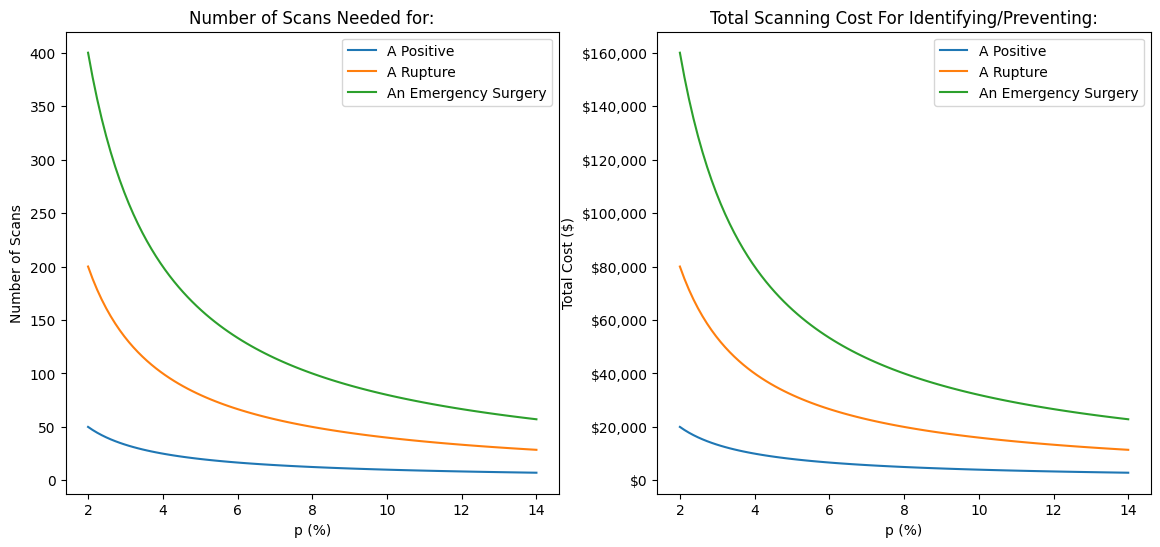

In [7]:
scans2find()